대회명 : Spooky Author Identification

노트북 출처 : https://www.kaggle.com/code/sudalairajkumar/simple-feature-engg-notebook-spooky-author/notebook

대회의 목적
공용도메인의 spooky 작가에의해 작성된 소설 텍스트가 포함되어있다.
1. 에드거 앨런 포(EAP)
2. HP 러브크래프트(HPL)
3. 메리 울스턴 크래프트(MWS)

목표는 테스트셋에서 문장의 저자를 확인하는 것이다.

이 노트북의 목표:
spooky 작가를 식별하는데 도움을 주는 다른 특징들을 만드는 것을 목표로 한다.
처음 단계로, feature engineering을 하기 전 간단한 시각화와 데이터클리닝을 할 것이다.

In [1]:
import numpy as np #선형대수
import pandas as pd #데이터 처리. csv 파일
import matplotlib.pyplot as plt
import seaborn as sns
import nltk #natural language tool kit
from nltk.corpus import stopwords
nltk.download("stopwords")
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
# train, test데이터셋을 읽고 맨 위 몇 라인을 확인한다.
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
print("train dataset의 수 : ",train_df.shape[0])
print("test dataset의 수 : ",test_df.shape[0])

train dataset의 수 :  19579
test dataset의 수 :  8392


In [3]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


각 저자의 출현 횟수를 확인하고 클래스가 균형을 이루고 있는지 확인할 수 있다.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51089 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0.0, flags=f

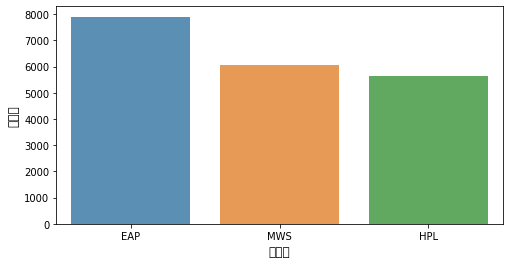

In [4]:
cnt_srs = train_df["author"].value_counts() #count_series???

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel("빈도수", fontsize = 12)
plt.xlabel("작가명", fontsize = 12)
plt.show()

불균형이 크지가 않다. 가능하다면 그들의 글쓰기 스타일을 이해하기위해 작가들의 일부 글을 프린트해보자

In [5]:
grouped_df = train_df.groupby("author")
for name, group in grouped_df:
    print("작가명 : ", name)
    cnt = 0
    
    #iterrows : pandas 함수 중 하나.
    #행에대해 순환반복을 할 때 사용 => 각 행의 값을 출력할 떄 사용
    #ind는 index, row는 id를 나타냄
    for ind, row in group.iterrows():
        print(row["text"])
        cnt +=1
        if cnt ==5:
            break
    print("\n")

작가명 :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you could not av

현재 텍스트 데이터에 상한한 특수문자가 있다. 이러한 특수문자의 수는 좋은 기능일 수 있고, 아마 나중에 만들 수 있을 것이다

그 외에는 단서가 별로 없다. 이 경우 우리가 만들 수 있는 흥미로운 스타일을 발견했다면(작가의 문체나 글의 특징등을 말하는 듯) 코멘트를 부탁한다.

피쳐 엔지니어링: 두 가지의 메인 파트로 나뉘어진다
1. meta feature : 단어의 수, 불용어의 수, 구둣점의 수와 같은 텍스트에서 추출된 특성
2. 텍스트에 기반한 특성 : 빈도, svd, word2vec 등과 같은 텍스트/단어를 직접 기반으로 하는 특성

meta features:
메타 기능을 만드는 것부터 시작하여 얼마나 spooky 작가를 잘 예측하는지 볼 것이다.
목록은 다음과 같다.
1. 텍스트에서 단어의 수
2. 텍스트에서 유니크한 단어의 수
3. 텍스트에서 문자의 수
4. 불용어의 수
5. 구둣점의 수
6. 대문자의 수
7. 제목케이스의 수
8. 단어의 평균 길이

In [6]:
#텍스트에서 단어의 수
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

# 텍스트에서 유니크한 단어의 수 = 중복되지 않는?
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

# 텍스트에서 문자의 수
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

# 텍스트에서 불용어의 수
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

# 텍스트에서 구둣점의 수
# 구둣점을 지우기 위해 string.punctuations를 사용. 정규표현식으로 지우는 방법도 있음
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

# 대문자의 수(원래 노트북에는 제목 케이스의 수라고 되어있으나 내용은 대문자의 수 확인)
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# 제목 케이스의 수
# istitle을 사용하여 각 단어의 첫글자가 대문자면 True, 아니면 Else를 반환
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# 단어의 평균 길이
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

예측에 도움이 될 몇 가지 새로운 변수를 plot할 것이다

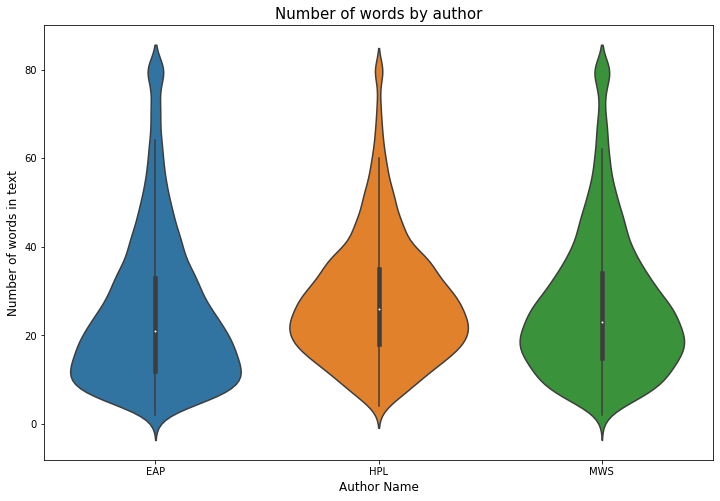

In [7]:
train_df["num_words"].loc[train_df["num_words"]>80] = 80 #더 나은 시각화를 위해 자름
plt.figure(figsize=(12,8))
sns.violinplot(x="author", y="num_words", data = train_df)
plt.xlabel("Author Name", fontsize=12)
plt.ylabel("Number of words in text", fontsize=12)
plt.title("Number of words by author", fontsize=15) #작가별 단어의 수
plt.show()

eap는 다른 둘에 비해 단어 수가 적은 것 같다

In [8]:
train_df["num_punctuations"]

0        7
1        1
2        5
3        4
4        4
        ..
19574    3
19575    1
19576    2
19577    3
19578    2
Name: num_punctuations, Length: 19579, dtype: int64

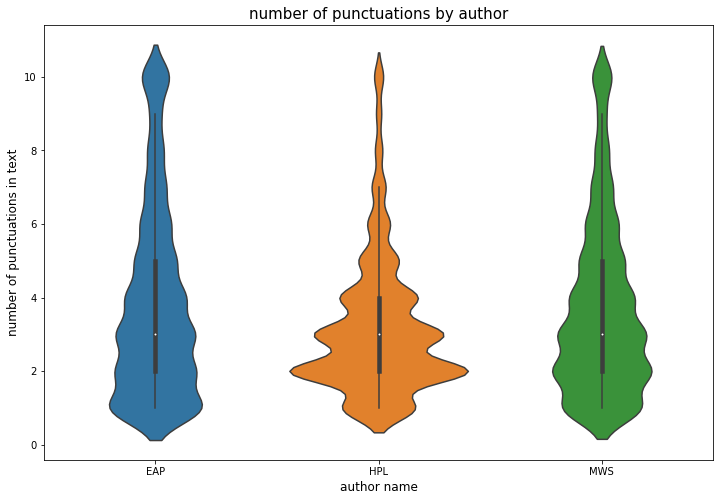

In [9]:
#구둣점이 10을 초과하면 그 값을 10으로 설정
train_df["num_punctuations"].loc[train_df["num_punctuations"]>10] = 10 # 나은 시각화를 위해 일부 잘라냄
plt.figure(figsize=(12,8))
sns.violinplot(x="author", y="num_punctuations", data= train_df)
plt.xlabel("author name", fontsize=12)
plt.ylabel("number of punctuations in text", fontsize=12)
plt.title("number of punctuations by author", fontsize=15)
plt.show()

이 plot도 다소 유용한 것처럼 보인다. 이제 텍스트 기반의 특징을 만드는 것에 집중할 것이다.
이러한 메타 기능이 어떻게 도움이 되는지 알아보기위해 기본모델을 구축할 것이다

In [10]:
# 모델링을 위한 데이터 준비
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

# 잘린 변수들을 다시 계산
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

이러한 메타기능만으로 간단한 xgboost를 훈련할 수 있다

In [11]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

커널 실행 시간을 위해 점수에 대한 k폴드 교차검증의 첫번째 폴드만 확인할 수 있습니다.
로컬에서 실행하는동안 "중단"줄을 제거하십시오

In [12]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[11:27:55] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.09371	test-mlogloss:1.09453
[20]	train-mlogloss:1.04138	test-mlogloss:1.05172
[40]	train-mlogloss:1.02343	test-mlogloss:1.03983
[60]	train-mlogloss:1.01043	test-mlogloss:1.03051
[80]	train-mlogloss:1.00001	test-mlogloss:1.02301
[100]	train-mlogloss:0.99206	test-mlogloss:1.01754
[120]	train-mlogloss:0.98398	test-mlogloss:1.01192
[140]	train-mlogloss:0.97747	test-mlogloss:1.00829
[160]	train-mlogloss:0.97233	test-mlogloss:1.00502
[180]	train-mlogloss:0.96712	test-mlogloss:1.00192
[200]	train-mlogloss:0.96284	test-mlogloss:1.00031
[220]	train-mlogloss:0.95900	test-mlogloss:0.99919
[240]	train-mlogloss:0.95459	test-mlogloss:0.99709
[260]	train-mlo

/opt/conda/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


메타 기능만 사용하여 0.987의 mlogloss를 얻었다. 나쁘지 않은 점수이다.
이러한 기능 중 어떤 것이 중요한지 살펴볼 것이다

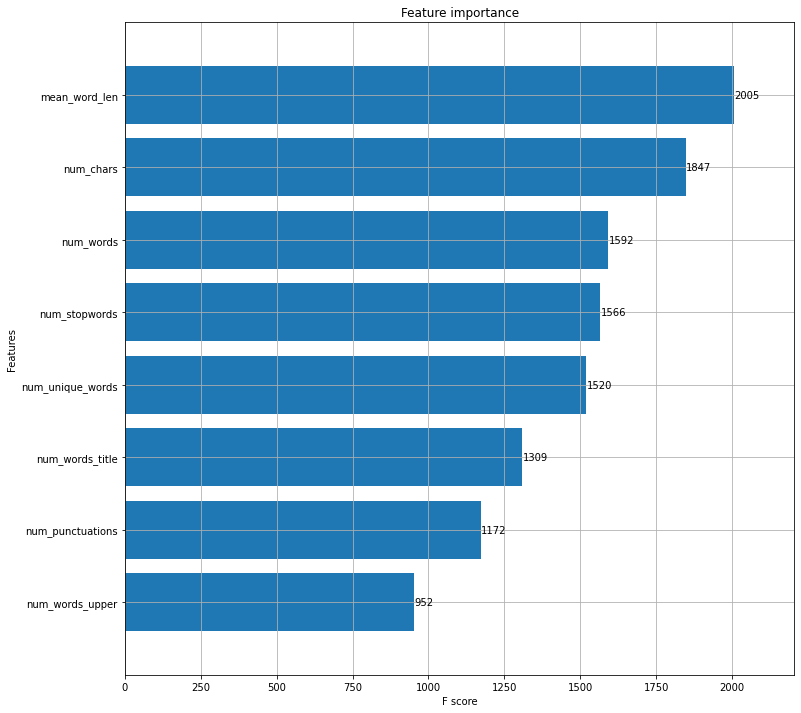

In [13]:
# 중요변수 plot
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

문자 수, 평균 단어 길이 및 고유 단어 수가 상위 3개 변수인 것으로 나타났다.
이제 몇 가지 텍스트 기반 기능을 만드는 데 집중할 것이다.

텍스트 기반:
우리가 만들 수 있는 기본 기능 중 하나는 tf-idf 값이다.

In [14]:
# tf-idf vectorizer 변환
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

tf-idf 벡터를 얻었지만 tricky한 부분이 있다.
tfidf 출력은 희소행렬이므로 다른 기능과 사용해야하는 경우 몇 가지 선택사항이 있다

1. tfidf에서 상위 n기능을 가져오도록 선택하고(밀도가높은순서), 고밀도 형식으로 변환하여 다른 기능과 연결할 수 있다.
2. 희소 특성을 이용하여 모델을 작성한 다음 다른 밀집 특성과 함께 특성 중 하나로 예측을 사용한다.

데이터 셋을 기반으로 할 때 하나는 다른 것에 비하면 더 잘 수행될 수 있다. 여기서 tfidf의 모든 기능을 사용하는 아주 좋은 스코어링 커널이 있기 때문에 두 번째 접근방식을 사용할 수 있다.

naive bayes가 데이터셋에서 나은 성능을 보이는 것 같다. 따라서 tfidf를 사용하여 나이브 베이즈 모델을 구축할 수 있다.(train 하는데 더 빠르다)

In [15]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

tfidf에서의 나이브 베이즈

In [16]:
#행의 갯수가 추가됨
copy= train_df.shape[0]
copy

19579

In [17]:
#np.zeros에서 3은 열의 갯수를 의미하는듯
ppp = np.zeros([copy, 3])
ppp

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [18]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.8422161983612855


tfidf를 사용하여 0.844의 mlogloss = (multiclass log loss)를 얻었다. 메타기능보다 훨씬 좋다.
혼동행렬을 살펴보겠다.

mlogloss는 3개이상을 분류할때 사용되는 로스값이라고 함

In [19]:
#혼동행렬 생성 기능
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes, normalize = False, title = "Confusion matrix", cmap = plt.cm.Blues):
    """
    이 기능은 혼동행렬을 plot과 출력을 한다. 정규화는 normalize=True로 시킬경우 가능하다
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis = 1)[:,np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)
    
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

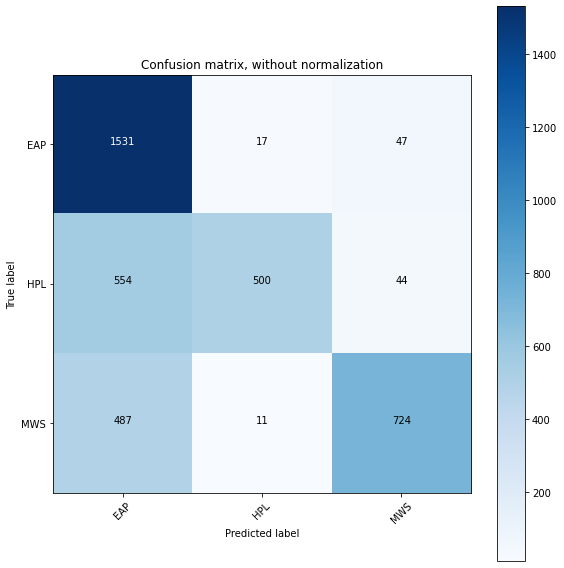

In [20]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis = 1))
np.set_printoptions(precision=2)

# 정규화되지않은 혼동행렬 plot
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=["EAP", "HPL", "MWS"],
                     title= "Confusion matrix, without normalization")
plt.show()

많은 요소가 eap로 예측되고 해당클래스에 크게 치우쳐져있다.

tfidf에서 svd

tfidf 벡터가 희소하기 때문에 정보를 압축하고 나타내는 간편한 방법은 svd를 통한 방법이다.
또한 일반적으로 svd특성은 과거 텍스트기반대회에서 잘 수행되었다.(필자 본인에게)
따라서 tfidf에 svd기능을 만들어 기능을 추가했다.

In [21]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm="arpack")
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

count vectorizer의 나이브베이즈

In [22]:
# count vectorizer를 변환
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

이제 count vectorizer 기반 기능을 사용하여 다항 nb 모델을 구축하겠다

In [23]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.45091841616567435


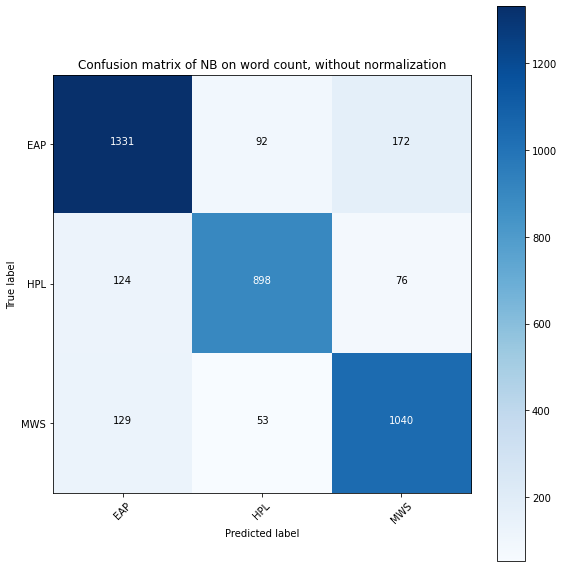

In [24]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# 정규화하지 않은 혼동행렬 plot
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

tfidf vectorizer대신 count vectorizer를 사용하여 0.451의 검증 mlogloss를 얻었다.
혼동행렬은 이전 것보다 더 좋아졌다

count vectorizer에서의 나이브 베이즈

데이터 eyeballing에서의 아이디어는 특수문자를 세는 것이 도움이 될 수 있다는 것이다.
단순히 특수문자를 세는 것보다, 문자 수준에서 count vectorizer를 사용하여 일부 기능을 얻을 수 있다.
다시 다항식 nb를 사용할 수 있다

In [25]:
#tfidf vectorizer 변환
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# 새로운 특성으로서 예측값 추가
train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

Mean cv score :  3.7507639226818825


교차검증 스코어는 매우 높고 3.75이다.
그러나, 이것은 단어 수준기능과 다른 정보를 추가할 수 있으므로 최종모델에서도 사용할 것이다. 

문자 tfidf vectorizer에서의 나이브 베이즈
또한 문자 tfidf vectorizer에 대한 나이브 베이즈 예측을 얻을 것이다.

In [26]:
#tfidf vectorizer 변환
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.790415258947421


문자 tfidf에서의 svd
또한 문자 tfidf기능에 svd를 생성하고 모델링에 사용할 수 있다

In [27]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ["svd_char_" + str(i) for i in range(n_comp)]
test_svd.columns = ["svd_char_" + str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

xgboost 모델
xgboost를 돌리고 결과를 평가할 수 있다

In [28]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[11:29:54] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.00262	test-mlogloss:1.00252
[20]	train-mlogloss:0.41109	test-mlogloss:0.41589
[40]	train-mlogloss:0.33948	test-mlogloss:0.35240
[60]	train-mlogloss:0.31341	test-mlogloss:0.33440
[80]	train-mlogloss:0.29647	test-mlogloss:0.32526
[100]	train-mlogloss:0.28293	test-mlogloss:0.31859
[120]	train-mlogloss:0.27179	test-mlogloss:0.31501
[140]	train-mlogloss:0.26192	test-mlogloss:0.31270
[160]	train-mlogloss:0.25337	test-mlogloss:0.31045
[180]	train-mlogloss:0.24571	test-mlogloss:0.30960
[200]	train-mlogloss:0.23833	test-mlogloss:0.30838
[220]	train-mlogloss:0.23157	test-mlogloss:0.30682
[240]	train-mlogloss:0.22475	test-mlogloss:0.30611
[260]	train-mlo

/opt/conda/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.3055의 val 점수와 0.32의 lb점수를 얻을 수 있다.
다시 중요 변수를 체크해보자

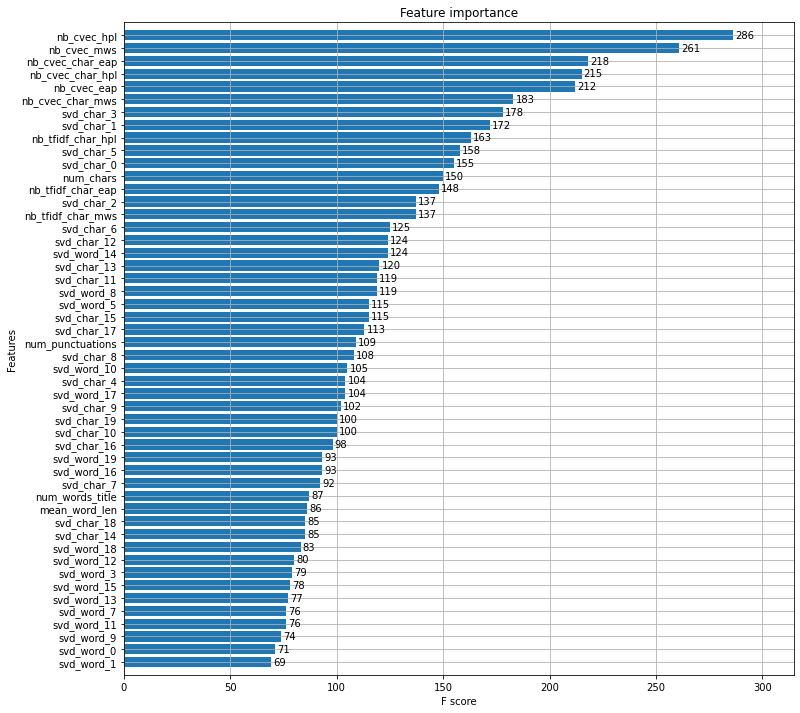

In [29]:
# 중요한 변수 plot
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

나이브 베이즈는 예상대로 최고의 기능이다.
오분류 오류를 확인하기위해 정오분류표를 구할 것이다

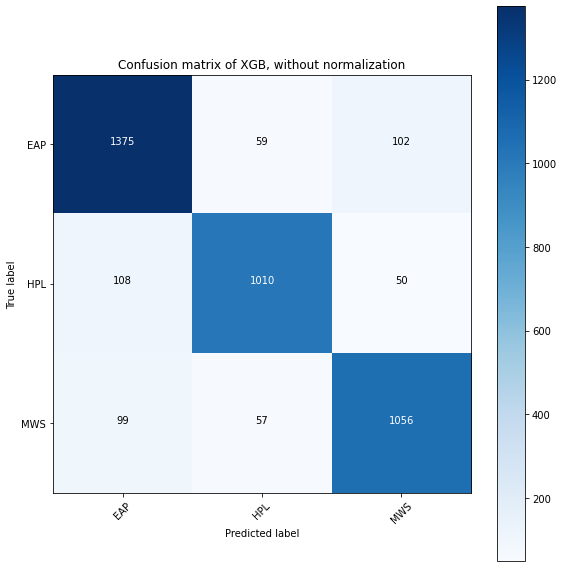

In [30]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()

eap와 mws는 다른 것보다 더 자주 잘못 분류되는 것 같다.
이 쌍에 대한 예측을 개선하는 기능을 잠재적으로 생성할 수 있다.

이 fe 노트북의 다음 단계
- 기본 feature에 워드임베딩 사용
- 다른 meta feature들
- 문장 감성 분석

다른 개선사항을 위한 아이디어
- tfidf 와 count vectorizer 파라미터 튜닝
- 나이브베이즈와 xgb 모델에 대한 파라미터 튜닝
- 앙상블 및 다른 모델을 쌓기